In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import linalg as LA

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

In [54]:
# Set parameters for the dataset
n_samples = 5000     # Number of observations
n_features = 50      # Total number of features
n_relevant = 30      # Number of relevant features
n_irrelevant = n_features - n_relevant  # Number of irrelevant features

# Generate feature data
np.random.seed(42)  # For reproducibility
X = np.random.randn(n_samples, n_features)

# Generate coefficients
true_coefficients = np.zeros(n_features)
true_coefficients[:n_relevant] = np.random.randn(n_relevant)

# Sum and print the L1 norm of the true coefficients
print(f'L1 norm of true coefficients: {np.sum(np.abs(true_coefficients))}')

# Generate the outcome variable with some noise
noise = np.random.randn(n_samples)/100
y = np.dot(X, true_coefficients) + noise

# Convert to DataFrame for easier handling
df_features = pd.DataFrame(X, columns=[f'feature_{i+1}' for i in range(n_features)])
df_target = pd.DataFrame(y, columns=['target'])

df = pd.concat([df_features, df_target], axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, random_state=42)


L1 norm of true coefficients: 29.416687834929114


In [58]:
n_list = list(range(1, n_features+1))
mse_list = []
testacc_list = []
# Compute the nth principal component of the training and testing data
for n in tqdm(n_list, desc='Computing principal components', leave=False):
    #print(f'Principal components: {n}\n')

    # Initialize the PCA transformer and fit it to the training data
    pca = PCA(n_components=n)
    pca.fit(X_train)

    # Transform the training and testing data
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Initialize the LASSO regressor
    lr = Lasso(alpha=0.1)

    # Fit the model to the training data
    lr.fit(X_train_pca, y_train)

    # Compute the predictions on the testing data
    y_pred = lr.predict(X_test_pca)

    # Compute and print the MSE
    mse = mean_squared_error(y_test, y_pred)
    #print(f'MSE: {mse:.2f} \t Test set performance: {lr.score(X_test_pca, y_test):.2f}\n')

    # Append the results to the lists
    mse_list.append(mse)
    testacc_list.append(lr.score(X_test_pca, y_test))

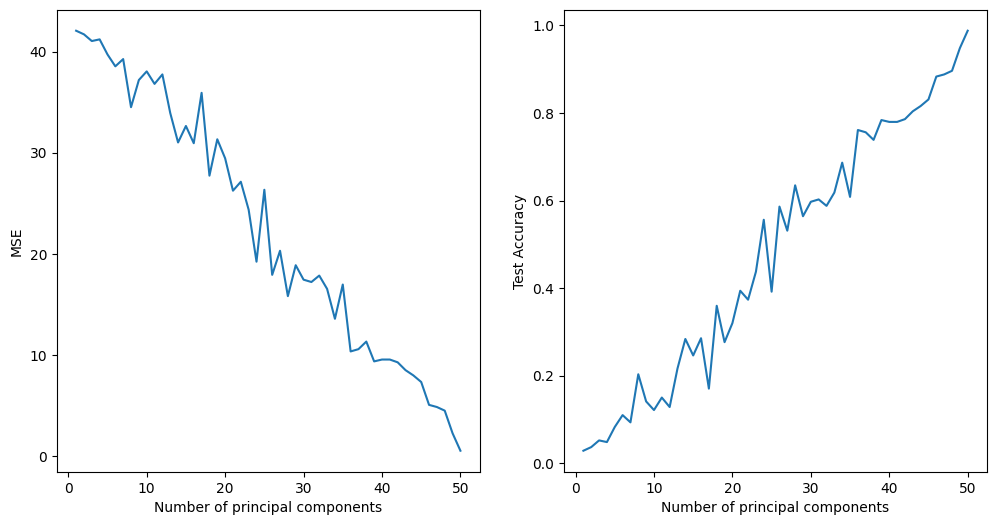

In [60]:
# Plot MSE and test set performance with respect to the number of principal components
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(n_list, mse_list)
ax[0].set_xlabel('Number of principal components')
ax[0].set_ylabel('MSE')
ax[0].set_title('')
ax[1].plot(n_list, testacc_list)
ax[1].set_xlabel('Number of principal components')
ax[1].set_ylabel('Test Accuracy')
ax[1].set_title('')
plt.show()

In [82]:
# MNIST
train_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = MNIST(root='data/', download=True, transform=train_transform)
test_dataset = MNIST(root='data/', train=False, transform=test_transform)

# Subsample MNIST so that each class has 100 train and 100 test samples
samples_per_class = 500
def subsample_mnist(dataset, n=samples_per_class):
    idxs = np.concatenate([np.where(dataset.targets==i)[0][:n] for i in range(10)])
    return torch.utils.data.Subset(dataset, idxs)

dataset = subsample_mnist(dataset)
test_dataset = subsample_mnist(test_dataset) 

# Create a data loader from the dataset
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create a model class
class MNISTModel(nn.Module):
    def __init__(self, kernel_dim=100):
        super().__init__()
        self.linear = nn.Linear(28*28, kernel_dim)
        self.classifier = nn.Linear(kernel_dim, 10)

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = F.relu(self.linear(x))
        out = self.classifier(x)
        return out


Kernel dimension: 100
Alpha: 0


Train loss: 0.32 	 Train acc: 0.91 	 Test loss: 0.02 	 Test acc: 86.04


Alpha: 0.001


Train loss: 0.38 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.98


Alpha: 0.005


Train loss: 0.21 	 Train acc: 0.91 	 Test loss: 0.02 	 Test acc: 86.08


Alpha: 0.01


Train loss: 0.57 	 Train acc: 0.91 	 Test loss: 0.02 	 Test acc: 85.90


Alpha: 0.05


Train loss: 0.39 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.78


Alpha: 0.1


Train loss: 0.77 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.96


Alpha: 0.5


Train loss: 1.37 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.52


Alpha: 1


Train loss: 2.38 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.76


Alpha: 5


Train loss: 5.87 	 Train acc: 0.58 	 Test loss: 0.06 	 Test acc: 55.90


Alpha: 10


Train loss: 13.68 	 Train acc: 0.45 	 Test loss: 0.07 	 Test acc: 38.28


Alpha: 50


Train loss: 324.33 	 Train acc: 0.30 	 Test loss: 0.06 	 Test acc: 29.54


Alpha: 100


Train loss: 1676.51 	 Train acc: 0.50 	 Test loss: 0.05 	 Test acc: 47.60


Alpha: 500


Train loss: 51820.87 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.32


Alpha: 1000


Train loss: 214083.80 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.92


Alpha: 5000


Train loss: 5466144.50 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 85.00


Alpha: 10000


Train loss: 21910338.00 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 83.40




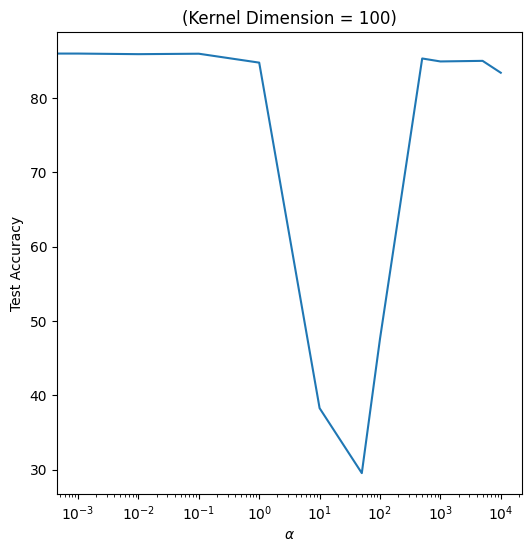

Kernel dimension: 75
Alpha: 0


Train loss: 0.27 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 86.66


Alpha: 0.001


Train loss: 0.24 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.86


Alpha: 0.005


Train loss: 0.13 	 Train acc: 0.91 	 Test loss: 0.02 	 Test acc: 85.98


Alpha: 0.01


Train loss: 0.23 	 Train acc: 0.91 	 Test loss: 0.02 	 Test acc: 86.02


Alpha: 0.05


Train loss: 1.01 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.62


Alpha: 0.1


Train loss: 0.45 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.98


Alpha: 0.5


Train loss: 1.79 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.30


Alpha: 1


Train loss: 2.46 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 83.74


Alpha: 5


Train loss: 4.87 	 Train acc: 0.42 	 Test loss: 0.07 	 Test acc: 40.36


Alpha: 10


Train loss: 10.76 	 Train acc: 0.16 	 Test loss: 0.07 	 Test acc: 17.22


Alpha: 50


Train loss: 251.32 	 Train acc: 0.31 	 Test loss: 0.07 	 Test acc: 30.54


Alpha: 100


Train loss: 1260.96 	 Train acc: 0.60 	 Test loss: 0.05 	 Test acc: 57.96


Alpha: 500


Train loss: 39786.41 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.50


Alpha: 1000


Train loss: 164188.14 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.36


Alpha: 5000


Train loss: 4219617.00 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 83.70


Alpha: 10000


Train loss: 16922464.00 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.48




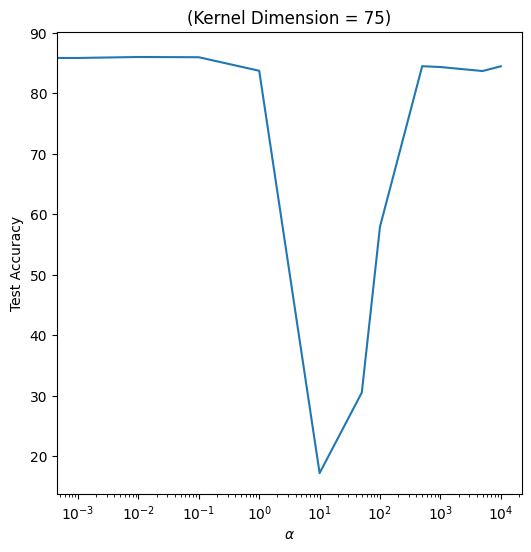

Kernel dimension: 50
Alpha: 0


Train loss: 0.64 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.88


Alpha: 0.001


Train loss: 0.22 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.18


Alpha: 0.005


Train loss: 0.33 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.98


Alpha: 0.01


Train loss: 0.80 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.78


Alpha: 0.05


Train loss: 0.92 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.78


Alpha: 0.1


Train loss: 0.48 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.60


Alpha: 0.5


Train loss: 1.42 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.94


Alpha: 1


Train loss: 2.03 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 84.02


Alpha: 5


Train loss: 3.98 	 Train acc: 0.24 	 Test loss: 0.07 	 Test acc: 21.76


Alpha: 10


Train loss: 7.92 	 Train acc: 0.18 	 Test loss: 0.07 	 Test acc: 17.60


Alpha: 50


Train loss: 176.31 	 Train acc: 0.26 	 Test loss: 0.07 	 Test acc: 24.94


Alpha: 100


Train loss: 888.23 	 Train acc: 0.46 	 Test loss: 0.06 	 Test acc: 44.56


Alpha: 500


Train loss: 27588.28 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.70


Alpha: 1000


Train loss: 115173.71 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 83.62


Alpha: 5000


Train loss: 2971217.50 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 82.96


Alpha: 10000


Train loss: 11912765.00 	 Train acc: 0.87 	 Test loss: 0.02 	 Test acc: 82.94




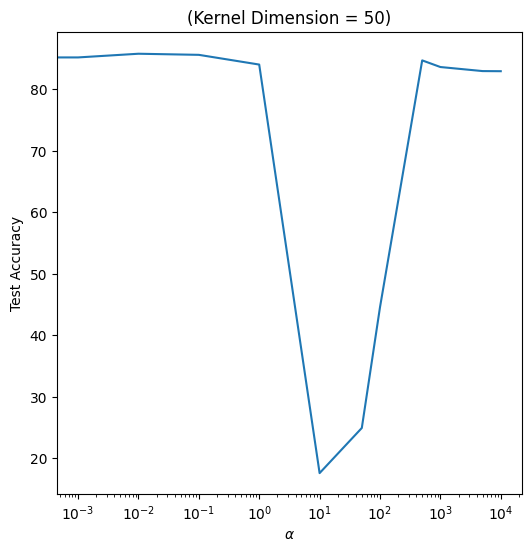

Kernel dimension: 25
Alpha: 0


Train loss: 0.76 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.34


Alpha: 0.001


Train loss: 0.14 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.76


Alpha: 0.005


Train loss: 0.30 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.44


Alpha: 0.01


Train loss: 0.29 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.76


Alpha: 0.05


Train loss: 0.36 	 Train acc: 0.90 	 Test loss: 0.02 	 Test acc: 85.32


Alpha: 0.1


Train loss: 0.37 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.98


Alpha: 0.5


Train loss: 1.05 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 84.18


Alpha: 1


Train loss: 1.80 	 Train acc: 0.87 	 Test loss: 0.03 	 Test acc: 82.28


Alpha: 5


Train loss: 3.27 	 Train acc: 0.15 	 Test loss: 0.07 	 Test acc: 13.42


Alpha: 10


Train loss: 5.59 	 Train acc: 0.11 	 Test loss: 0.07 	 Test acc: 10.84


Alpha: 50


Train loss: 96.67 	 Train acc: 0.23 	 Test loss: 0.07 	 Test acc: 21.22


Alpha: 100


Train loss: 481.93 	 Train acc: 0.19 	 Test loss: 0.07 	 Test acc: 16.42


Alpha: 500


Train loss: 15130.23 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 82.82


Alpha: 1000


Train loss: 64741.82 	 Train acc: 0.86 	 Test loss: 0.02 	 Test acc: 81.00


Alpha: 5000


Train loss: 1722451.12 	 Train acc: 0.87 	 Test loss: 0.02 	 Test acc: 82.10


Alpha: 10000


Train loss: 6927452.00 	 Train acc: 0.85 	 Test loss: 0.02 	 Test acc: 80.20




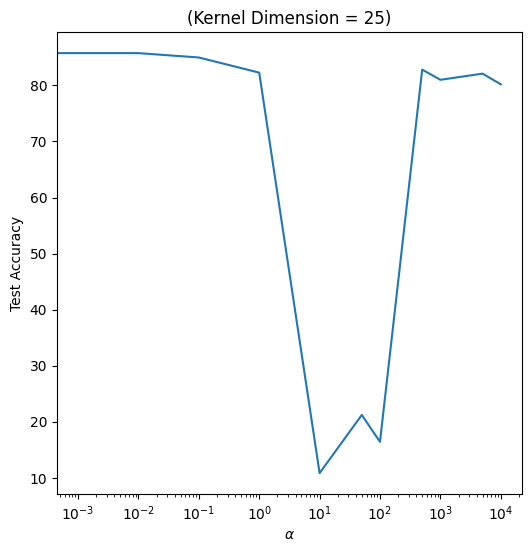

Kernel dimension: 10
Alpha: 0


Train loss: 0.45 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 82.86


Alpha: 0.001


Train loss: 0.58 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 82.92


Alpha: 0.005


Train loss: 0.21 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.34


Alpha: 0.01


Train loss: 0.29 	 Train acc: 0.89 	 Test loss: 0.02 	 Test acc: 84.10


Alpha: 0.05


Train loss: 1.03 	 Train acc: 0.87 	 Test loss: 0.02 	 Test acc: 82.90


Alpha: 0.1


Train loss: 0.76 	 Train acc: 0.88 	 Test loss: 0.02 	 Test acc: 83.56


Alpha: 0.5


Train loss: 1.27 	 Train acc: 0.86 	 Test loss: 0.03 	 Test acc: 81.32


Alpha: 1


Train loss: 2.20 	 Train acc: 0.80 	 Test loss: 0.03 	 Test acc: 74.98


Alpha: 5


Train loss: 2.81 	 Train acc: 0.14 	 Test loss: 0.07 	 Test acc: 15.18


Alpha: 10


Train loss: 4.25 	 Train acc: 0.11 	 Test loss: 0.07 	 Test acc: 10.22


Alpha: 50


Train loss: 52.73 	 Train acc: 0.10 	 Test loss: 0.07 	 Test acc: 8.56


Alpha: 100


Train loss: 244.74 	 Train acc: 0.14 	 Test loss: 0.07 	 Test acc: 12.64


Alpha: 500


Train loss: 7393.43 	 Train acc: 0.74 	 Test loss: 0.03 	 Test acc: 67.58


Alpha: 1000


Train loss: 33738.25 	 Train acc: 0.81 	 Test loss: 0.02 	 Test acc: 74.14


Alpha: 5000


Train loss: 959966.31 	 Train acc: 0.45 	 Test loss: 0.05 	 Test acc: 42.20


Alpha: 10000


Train loss: 3829014.25 	 Train acc: 0.78 	 Test loss: 0.03 	 Test acc: 71.28




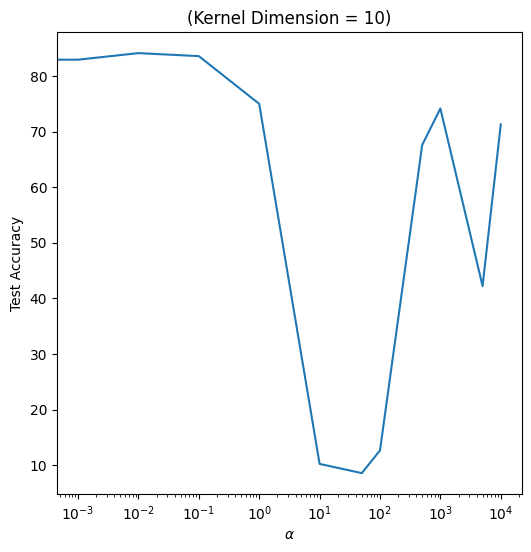

Kernel dimension: 5
Alpha: 0


Train loss: 0.76 	 Train acc: 0.80 	 Test loss: 0.03 	 Test acc: 76.52


Alpha: 0.001


Train loss: 1.41 	 Train acc: 0.80 	 Test loss: 0.03 	 Test acc: 74.88


Alpha: 0.005


Train loss: 0.71 	 Train acc: 0.79 	 Test loss: 0.03 	 Test acc: 74.08


Alpha: 0.01


Train loss: 2.05 	 Train acc: 0.62 	 Test loss: 0.04 	 Test acc: 57.88


Alpha: 0.05


Train loss: 1.51 	 Train acc: 0.77 	 Test loss: 0.03 	 Test acc: 70.28


Alpha: 0.1


Train loss: 1.18 	 Train acc: 0.70 	 Test loss: 0.03 	 Test acc: 64.54


Alpha: 0.5


Train loss: 1.92 	 Train acc: 0.69 	 Test loss: 0.04 	 Test acc: 63.62


Alpha: 1


Train loss: 1.91 	 Train acc: 0.42 	 Test loss: 0.06 	 Test acc: 40.94


Alpha: 5


Train loss: 2.71 	 Train acc: 0.10 	 Test loss: 0.07 	 Test acc: 10.00


Alpha: 10


Train loss: 3.77 	 Train acc: 0.12 	 Test loss: 0.07 	 Test acc: 11.30


Alpha: 50


Train loss: 39.73 	 Train acc: 0.12 	 Test loss: 0.07 	 Test acc: 13.28


Alpha: 100


Train loss: 184.40 	 Train acc: 0.06 	 Test loss: 0.07 	 Test acc: 6.94


Alpha: 500


Train loss: 5459.38 	 Train acc: 0.19 	 Test loss: 0.07 	 Test acc: 17.78


Alpha: 1000


Train loss: 23766.65 	 Train acc: 0.45 	 Test loss: 0.05 	 Test acc: 42.58


Alpha: 5000


Train loss: 709798.19 	 Train acc: 0.53 	 Test loss: 0.05 	 Test acc: 49.70


Alpha: 10000


Train loss: 2818840.00 	 Train acc: 0.33 	 Test loss: 0.07 	 Test acc: 30.16




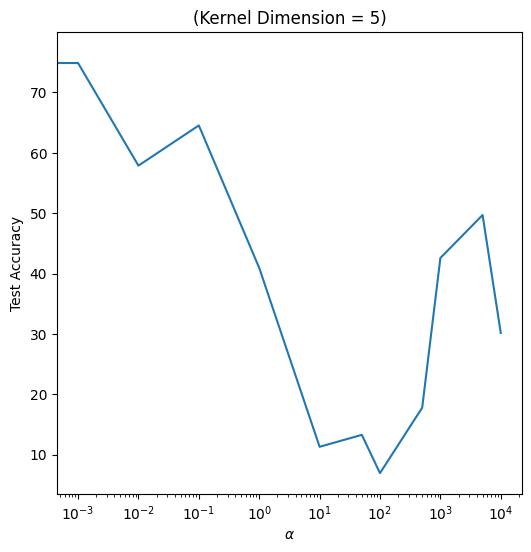

In [85]:
for k_dim in [100, 75, 50, 25, 10, 5]:
    print(f'Kernel dimension: {k_dim}')

    train_loss_evolutions = {0: [], 0.001: [], 0.005: [], 0.01: [], 0.05: [], 0.1: [], 0.5: [], 1: [], 5: [], 10: [], 50: [], 100: [], 500: [], 1000: [], 5000: [], 10000: []}
    test_loss_evolutions = {0: [], 0.001: [], 0.005: [], 0.01: [], 0.05: [], 0.1: [], 0.5: [], 1: [], 5: [], 10: [], 50: [], 100: [], 500: [], 1000: [], 5000: [], 10000: []}
    train_acc_evolutions = {0: [], 0.001: [], 0.005: [], 0.01: [], 0.05: [], 0.1: [], 0.5: [], 1: [], 5: [], 10: [], 50: [], 100: [], 500: [], 1000: [], 5000: [], 10000: []}
    test_acc_evolutions = {0: [], 0.001: [], 0.005: [], 0.01: [], 0.05: [], 0.1: [], 0.5: [], 1: [], 5: [], 10: [], 50: [], 100: [], 500: [], 1000: [], 5000: [], 10000: []}
    for alpha in [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]:
        print(f'Alpha: {alpha}')

        # Initialize the model
        model = MNISTModel(kernel_dim=k_dim)

        # CE Loss
        loss_fn = nn.CrossEntropyLoss()
        alpha = alpha # Regularization parameter

        # Define the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001)

        # Define the training loop
        def train_loop(dataloader, model, loss_fn, optimizer, epoch):
            model.train()
            current = 0
            size = len(dataloader.dataset)
            for batch, (X, y) in enumerate(dataloader):
                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)
                l1_norm = sum(LA.norm(p, 1) for p in model.parameters())
                loss += alpha * l1_norm

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if batch % 100 == 0:
                    loss, current = loss.item(), batch*len(X)
                    #print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]', end='\r')s
            if (epoch+1) % 5 == 0:
                model.eval()
                # Calculate accuracy on training set
                correct = 0
                with torch.no_grad():
                    for X, y in dataloader:
                        pred = model(X)
                        correct += (pred.argmax(1)==y).type(torch.float).sum().item()
                acc = correct/size
            else:
                acc = 0
            return acc, loss.item()

        # Define the test loop
        def test_loop(dataloader, model, loss_fn, optimizer, epoch):
            model.eval()
            size = len(dataloader.dataset)
            test_loss, correct = 0, 0

            for X, y in dataloader:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1)==y).type(torch.float).sum().item()

            test_loss /= size
            correct /= size
            #print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n', end='\r')
            return 100*correct, test_loss

        # Train the model
        epochs = 30
        for epoch in tqdm(range(epochs), leave=False, desc='Epochs'):
            train_acc, train_loss = train_loop(train_loader, model, loss_fn, optimizer, epoch)
            test_acc, test_loss = test_loop(test_loader, model, loss_fn, optimizer, epoch)

            train_loss_evolutions[alpha].append(train_loss)
            test_loss_evolutions[alpha].append(test_loss)
            train_acc_evolutions[alpha].append(train_acc)
            test_acc_evolutions[alpha].append(test_acc)
        print(f'Train loss: {train_loss:.2f} \t Train acc: {train_acc:.2f} \t Test loss: {test_loss:.2f} \t Test acc: {test_acc:.2f}\n\n')

    # Plot the train and test acc with respect to alpha 
    alpha = [0, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]
    alpha_test_acc = [test_acc_evolutions[a][-1] for a in alpha]
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # log plot
    ax.semilogx(alpha, alpha_test_acc)
    ax.set_xlabel('$\\alpha$')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(f'(Kernel Dimension = {k_dim})')
    plt.show()
    # Save plot
    fig.savefig(f'figures/{k_dim}_test_acc.png', dpi=300)
